# Variational Autoencoders (VAEs) for CryptoPunks Dataset

## Introduction

This Jupyter notebook explores the application of Variational Autoencoders (VAEs) to the CryptoPunks dataset. CryptoPunks are unique digital collectibles on the Ethereum blockchain, consisting of 10,000 algorithmically generated characters with distinct attributes.


In [79]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datasets import load_dataset

In [57]:
# Training on Macbook Pro with M1 chip, using Metal Performance Shaders
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [69]:
# Load the dataset
dataset = load_dataset("huggingnft/cryptopunks", split="train")

# Define split ratio
train_ratio = 0.8

# Create the train-test split
split_dataset = dataset.train_test_split(test_size=1 - train_ratio)

# Access the train and test splits
train_data = split_dataset['train']
test_data = split_dataset['test']

In [71]:
# Function to convert image to tensor
def transform_func(img):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Transform image to 128x128
        transforms.PILToTensor(),  # Convert PIL Image to PyTorch tensor
        transforms.ConvertImageDtype(torch.float)   # Convert PIL Image to float
    ])
    return transform(img)

# Define class for Cryptopunks dataset
class PunkDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.transform = transform_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image = self.data_list[idx]["image"]
        if isinstance(image, Image.Image):
            image = self.transform(image)
        return image
    
# Initialize the Punk dataset for training and test sets
train_dataset = PunkDataset(train_data)
test_dataset = PunkDataset(test_data)

In [72]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [73]:
# Validate the dataset sizes that they are 80% and 20% of the total dataset
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 8000
Number of test samples: 2000


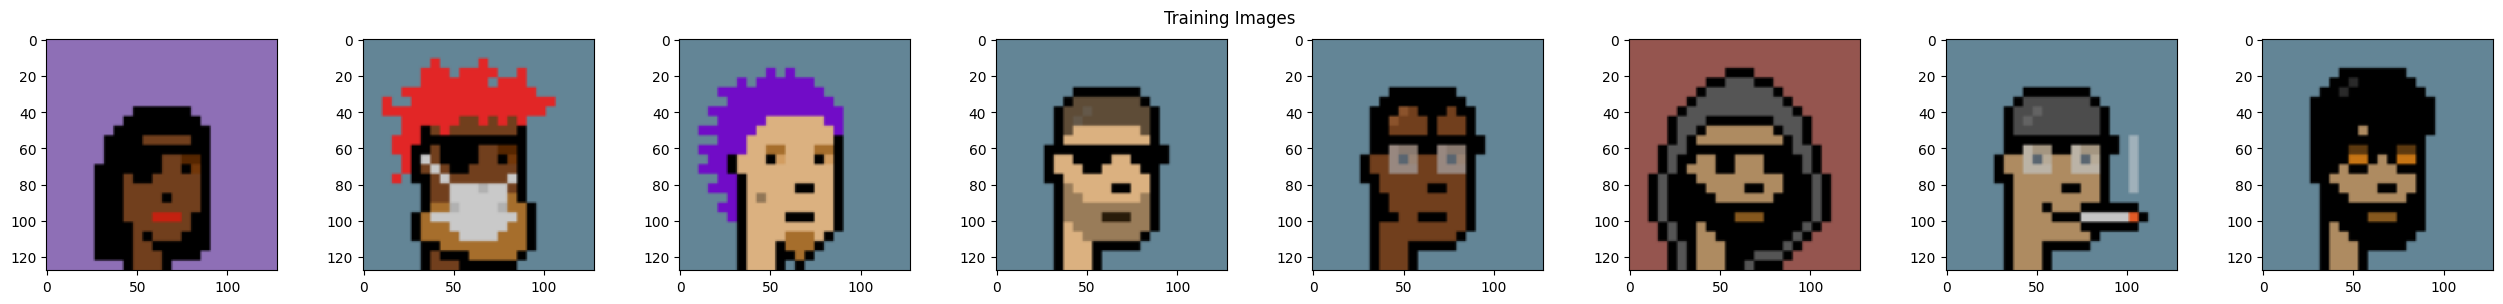

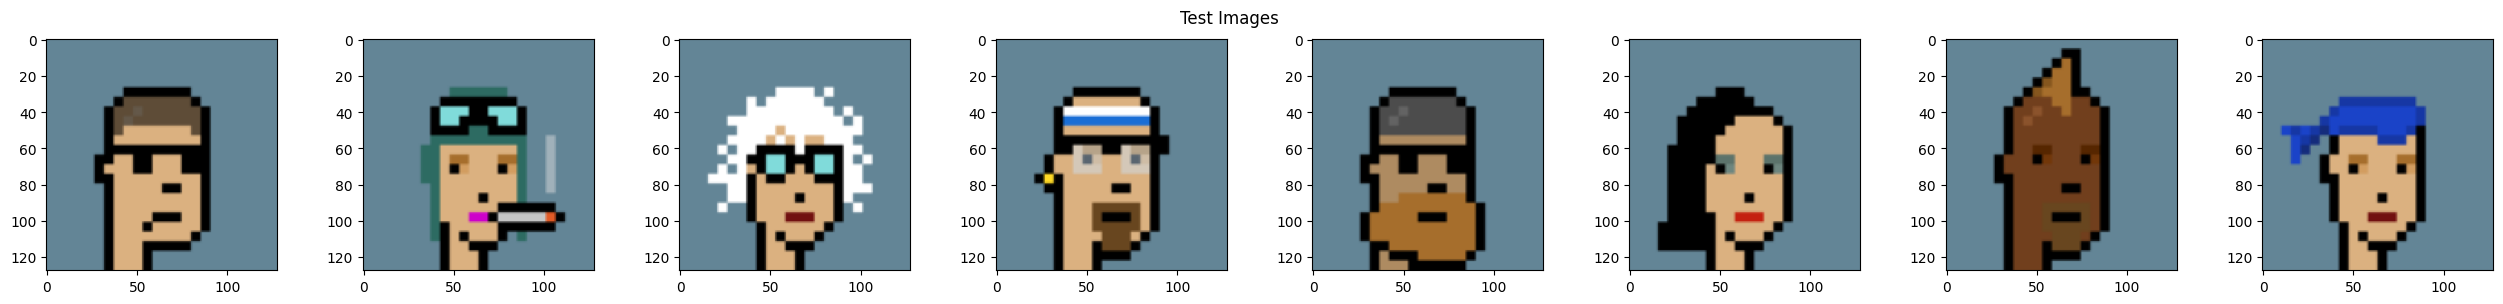

In [62]:
# Display images in a grid
def plot_images_from_loader(data_loader, title, num_images=8):
    """Display a set of images from the DataLoader in a grid."""
    # Get a batch of images
    images = next(iter(data_loader))
    
    # Create a grid from the images
    fig, axes = plt.subplots(1, num_images, figsize=(32, 3))
    fig.suptitle(title)
    
    # Plot each image
    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
        ax.imshow(image)
    plt.show()

# Display images from training and test loaders
plot_images_from_loader(train_loader, title="Training Images")
plot_images_from_loader(test_loader, title="Test Images")

In [74]:
# Encoding network based on a simple forward feed neural network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(128 * 128 * 3, 1024) 
        self.fc2 = nn.Linear(1024, 512)           
        self.fc3 = nn.Linear(512, 256)            
        self.fc4 = nn.Linear(256, 128)          
        self.fc5 = nn.Linear(128, 64)              
    
    def forward(self, x):
        x = x.view(-1, 128 * 128 * 3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [75]:
# Decoding network based on a simple forward feed neural network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(64, 128)          
        self.fc2 = nn.Linear(128, 256)          
        self.fc3 = nn.Linear(256, 512)          
        self.fc4 = nn.Linear(512, 1024)         
        self.fc5 = nn.Linear(1024, 128 * 128 * 3) 
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = x.view(-1, 3, 128, 128)  # Reshape to image dimensions
        return x

In [76]:
# Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [77]:
# Initialize the autoencoder
autoencoder = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
def train_autoencoder(dataloader, model, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Train the autoencoder
train_autoencoder(train_loader, autoencoder, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 0.0573
Epoch [2/20], Loss: 0.0317
Epoch [3/20], Loss: 0.0289
Epoch [4/20], Loss: 0.0251
Epoch [5/20], Loss: 0.0218
Epoch [6/20], Loss: 0.0201
Epoch [7/20], Loss: 0.0178
Epoch [8/20], Loss: 0.0162
Epoch [9/20], Loss: 0.0149
Epoch [10/20], Loss: 0.0138
Epoch [11/20], Loss: 0.0130
Epoch [12/20], Loss: 0.0125
Epoch [13/20], Loss: 0.0117
Epoch [14/20], Loss: 0.0112
Epoch [15/20], Loss: 0.0107
Epoch [16/20], Loss: 0.0101
Epoch [17/20], Loss: 0.0099
Epoch [18/20], Loss: 0.0091
Epoch [19/20], Loss: 0.0087
Epoch [20/20], Loss: 0.0084


Evaluation Loss: 0.0090


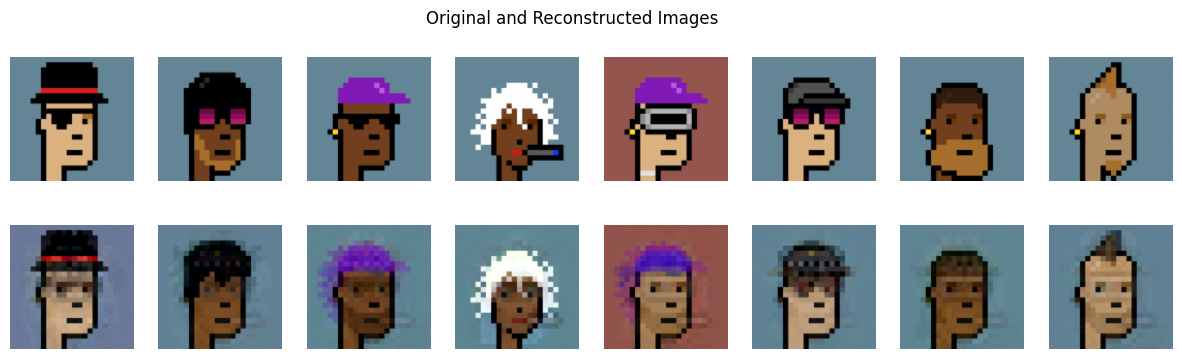

In [84]:
# Function to display original and reconstructed images along with the evaluation loss
def plot_reconstructed_images_with_loss(data_loader, model, criterion, num_images=8):
    model.eval() 
    
    running_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():  # No need to compute gradients
        images = next(iter(data_loader))
        
        images = images.to(next(model.parameters()).device)
        
        reconstructed_images = model(images)
        
        # Compute the loss
        loss = criterion(reconstructed_images, images)
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        
        # Compute average loss over the dataset
        average_loss = running_loss / total_samples
    
    print(f"Evaluation Loss: {average_loss:.4f}")
    
    # Convert images and reconstructed images to NumPy arrays for visualization
    images = images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    fig.suptitle("Original and Reconstructed Images")
    
    # Display original images
    for i in range(num_images):
        ax = axes[0, i]
        img = images[i].transpose(1, 2, 0)
        ax.imshow(np.clip(img, 0, 1)) 
        ax.axis('off')
    
    # Display reconstructed images
    for i in range(num_images):
        ax = axes[1, i]
        img = reconstructed_images[i].transpose(1, 2, 0) 
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
    
    plt.show()

# Call the function to display images and print evaluation loss
plot_reconstructed_images_with_loss(test_loader, autoencoder, criterion, num_images=8)

In [85]:
# Save the model state dictionary
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

# Save the entire model
torch.save(autoencoder, 'autoencoder_complete.pth')